### Coverage and log-prob $\theta^*$ plots

In [1]:
import pickle
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from rnpe.utils import get_manual_legend
from pickle import UnpicklingError

%load_ext autoreload
%autoreload 2

sns.set_context("paper", font_scale=1.225)
sns.set_style("whitegrid", {"font.family":"Times New Roman", "font.serif":"serif", "font.size": 11})
plt.rcParams["axes.grid"] = False

palette = {"RNPE": "#ECA918", "NNPE": "#2e6482", "NPE": "#60B3C8"}


from plotnine import (
    ggplot, aes, geom_line, scale_colour_manual,
    geom_abline, element_blank,
    facet_wrap, theme_bw, theme,
    coord_fixed, element_text
    )

results_dir = "../../results"
slab_scale = 0.25
hyperprior = False
misspecified = True
hyperparam_string = f"slab_scale={0.25}_hyperprior={hyperprior}_misspecified={misspecified}"
num_obs = 1000

In [ ]:
task_names = ["Gaussian", "GaussianLinear", "SIR", "CS"]
method_names = ["RNPE", "NNPE", "NPE"]
palette = {k: palette[k] for k in method_names}
results = {t: [] for t in task_names}

for task in task_names:
    task_dir = f"{results_dir}/{task}/"
    for seed in range(num_obs):
        f_name = task_dir + f"seed={seed}_{hyperparam_string}.pickle"
        try:
            with open(f_name, "rb") as f:
                res = pickle.load(f)
                results[task].append(res["metrics"])
        except (FileNotFoundError, UnpicklingError) as e:
            print(f"File {f_name} truncated or not found")


In [3]:
df_list = []
residual_list = []

for task in task_names:
    for method in method_names:
        task_em_res = [res[method] for res in results[task]]
        metrics = {k: [res[k] for res in task_em_res] for k in ["log_prob_theta*", "hpd"]}
        metrics["Task"] = task
        metrics["Method"] = method

        df_list.append(pd.DataFrame(metrics))

        residual_list.append(
            {"Method": method, "Task": task,
            "residuals": np.row_stack([r["point_estimate_residuals"] for r in task_em_res])
            })

df = pd.concat(df_list)
df["Method"] = pd.Categorical(df["Method"], categories=method_names)
df = df.reset_index(drop=True)
df["Task"] = df["Task"].str.replace("GaussianLinear","Gaussian Linear")
task_names = [t.replace("GaussianLinear", "Gaussian Linear") for t in task_names]


### Calculate coverage

In [4]:

confidence_level = np.linspace(0, 1, 1001)

cov_df_list = []
for task in task_names:
    for method in method_names:
        coverage = []
        for level in confidence_level:
            hpd_subset = df["hpd"][(df["Task"] == task) & (df["Method"] == method)]
            coverage.append(sum(hpd_subset/100 <= level)/len(hpd_subset))
        
        cov_df_list.append(
            pd.DataFrame({
                "Confidence Level": confidence_level,
                "Empirical Coverage": coverage,
                "Task": task,
                "Method": method
            })
        )
cov_df = pd.concat(cov_df_list)
cov_df = cov_df.reset_index(drop=True)
cov_df = cov_df.drop_duplicates(subset=["Empirical Coverage", "Task", "Method"])
cov_df["Method"] = pd.Categorical(cov_df["Method"], categories=reversed(method_names))
cov_df["Task"] = pd.Categorical(cov_df["Task"], categories=task_names)


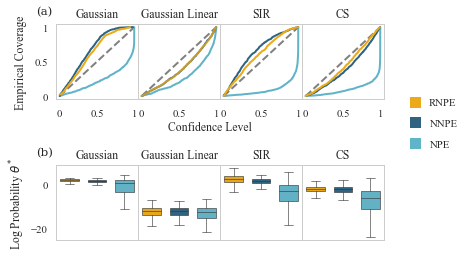

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=len(task_names), sharey="row")

for i, task in enumerate(task_names):
    ax[0, i].set_title(task)
    ax[1, i].set_title(task)

    ax[0, i].set_xticks([0, 0.5, 1])
    ax[0, i].set_xticklabels(["0", "0.5", "1"]) # Avoiding 0.0 and 1.0
    ax[0, i].set_yticks([0, 0.5, 1])
    ax[0, i].set_yticklabels(["0", "0.5", "1"]) # Avoiding 0.0 and 1.0
    
    ax[0, i].plot([0, 1], [0,1], "--", color="grey", linewidth=2)

    sns.lineplot(
        x="Confidence Level",
        y="Empirical Coverage",
        hue="Method",
        data=cov_df[cov_df["Task"] == task],
        palette=palette,
        linewidth=2,
        ax=ax[0, i],
    )

    sns.boxplot(
        x = "Method",
        y = "log_prob_theta*",
        labels=["Method"],
        showfliers=False,
        width=0.68,
        data=df[df["Task"] == task],
        palette=palette,
        saturation=0.95,
        linewidth=0.6,
        ax = ax[1, i])

    ax[1, i].get_xaxis().set_ticks([])

for a in ax.ravel():
    a.set_xlabel(None)
    a.set_ylabel(None)

for a in ax[0]:
    a.get_legend().remove()

ax[1, 0].set_ylabel(r"Log Probability $\theta^*$")
ax[0, 0].set_ylabel("Empirical Coverage")
fig.tight_layout()
fig.align_ylabels()
fig.subplots_adjust(wspace=0)
fig.subplots_adjust(hspace=0.86)

fig.text(0.53, 0.48, "Confidence Level", ha='center', fontdict={"fontsize": "medium"})

handles = get_manual_legend(palette.keys(), palette.values(), "s")

fig.legend(
    handles=handles,
    bbox_to_anchor=[1.18, 0.65],
    markerscale=1.5,
    handletextpad=0.3,
    labelspacing=1,
    frameon=False
    )

import matplotlib.transforms as mtransforms

for a, label in zip([ax[0,0], ax[1,0]], ["(a)", "(b)"]):
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    a.text(0.0, 1.0, label, transform=a.transAxes + trans,
                fontsize='medium', va='bottom', fontfamily='serif')


ax[0, 1].lines[3].set(alpha=0.8)  # Reduce alpha as overlapping

fig.set_size_inches(5.5,3.5)
plt.savefig(f"{results_dir}/plots/overall_{hyperparam_string}.pdf", bbox_inches="tight")

### Calculate residual

In [6]:
from rnpe.tasks import Gaussian, GaussianLinear, SIR, CS
residual_df_list = []
for r in residual_list:
    task_name = r["Task"]
    task = {"Gaussian": Gaussian(), "GaussianLinear": GaussianLinear(), "SIR": SIR(), "CS": CS()}[task_name]
    names = np.array(task.theta_names)
    n = r["residuals"].shape[0]
    r["Residuals"] = r["residuals"].flatten("F")
    r["Parameter"] = names.repeat(n)

    residual_df_list.append(pd.DataFrame(
        {k: r[k] for k in ["Residuals", "Parameter", "Task", "Method"]}
    ))
residual_df = pd.concat(residual_df_list)

In [7]:
residual_df["Squared Residuals"] = residual_df["Residuals"]**2

In [8]:
residual = residual_df.groupby(["Task", "Method", "Parameter"])["Squared Residuals"].mean()
residual = residual.reset_index()
residual = residual.pivot(columns=["Method"], index=["Task", "Parameter"])
residual.to_csv(f"{results_dir}/residual.csv", float_format="%.2f")
residual

Squared Residuals                    
Method                                  NNPE       NPE      RNPE
Task           Parameter                                        
CS             $\lambda_c$          0.118018  0.121009  0.125452
               $\lambda_d$          1.209938  1.917875  1.209041
               $\lambda_p$          0.800246  1.107495  0.751341
Gaussian       $\mu$                0.037549  0.160071  0.023640
GaussianLinear \theta_0             0.698677  0.756493  0.710277
               \theta_1             0.709840  0.742392  0.713167
               \theta_2             0.690996  0.740241  0.688214
               \theta_3             0.691600  0.727675  0.692976
               \theta_4             0.727077  0.787938  0.730961
               \theta_5             0.705555  0.760702  0.711132
               \theta_6             0.691915  0.748419  0.695988
               \theta_7             0.678536  0.751289  0.680613
               \theta_8             0.682071  0.725414  0.677659
               \theta_9             0.709780  0.739895  0.703522
SIR            $\beta$              0.199776  1.105498  0.158936
               $\gamma$             0.109832  0.599490  0.089423

In [9]:
residual.groupby("Task").mean()  # Means across the parameters

Squared Residuals                    
Method                      NNPE       NPE      RNPE
Task                                                
CS                      0.709401  1.048793  0.695278
Gaussian                0.037549  0.160071  0.023640
GaussianLinear          0.698605  0.748046  0.700451
SIR                     0.154804  0.852494  0.124179

### C2ST

In [10]:
df_list = []

tractable_tasks = ["Gaussian", "GaussianLinear"]
for task in tractable_tasks:
    for method in method_names:
        df_list.append(pd.DataFrame(
            {"Task": task,
            "Method": method,  
            "C2ST": [res[method]["C2ST"].item() for res in results[task]]
            }
        ))


c2st_df = pd.concat(df_list)
c2st_df["Method"] = pd.Categorical(c2st_df["Method"], categories=method_names)
c2st_df["Task"] = c2st_df["Task"].str.replace("GaussianLinear","Gaussian Linear")
c2st_df


,Task,Method,C2ST
0,Gaussian,RNPE,0.720700
1,Gaussian,RNPE,0.672500
2,Gaussian,RNPE,0.707250
3,Gaussian,RNPE,0.577000
4,Gaussian,RNPE,0.542050
...,...,...,...
994,Gaussian Linear,NPE,0.628150
995,Gaussian Linear,NPE,0.634750
996,Gaussian Linear,NPE,0.650900
997,Gaussian Linear,NPE,0.623751


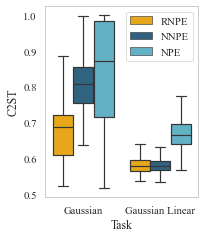

In [11]:
plt.figure(figsize = (5.5/2,3.5))
sns.boxplot(
    x="Task",
    y="C2ST",
    hue="Method",
    data=c2st_df,
    palette=palette,
    saturation=0.95,
    showfliers = False)
plt.legend()
plt.savefig(f"{results_dir}/plots/c2st_{hyperparam_string}.pdf", bbox_inches="tight")
